In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from abc import abstractmethod

In [69]:
class SyntheticOracle:
    dampened_rate: int = 0
    averaged_indices: int = 0

    @abstractmethod
    def latestAnswer(self, external_oracle_price: int) -> int:
        """External Oracle is an established of the oracle the derivative
        asset is being swapped into.

        :param external_oracle_price:
        :return:
        """
        raise NotImplementedError

    @abstractmethod
    def update_dampened_rate(self, swap_rate: int):
        """Calculate a dampened swap rate from derivative to source asset

        :param swap_rate:
        :return:
        """
        raise NotImplementedError

In [70]:
class EMARateOracle(SyntheticOracle):

    def update_dampened_rate(self, swap_rate: int):
        # averaging logic: https://stackoverflow.com/a/23493727

        self.averaged_indices += 1
        self.dampened_rate = int(
            (
                    self.dampened_rate *
                    (self.averaged_indices - 1) +
                    swap_rate
            ) / self.averaged_indices
        )

    def latestAnswer(self, external_oracle_price: int) -> int:

        return int(external_oracle_price * 10**10 * self.dampened_rate / 10 ** 18)


In [90]:
def plot_oracle_prices(pool_data, id_limits = None):

    if id_limits:
        pool_data = pool_data.iloc[id_limits[0]:id_limits[1]]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    ax.plot(
        pool_data.block,
        pool_data.oracle_price,
        color='red',
        label='Oracle Price'
    )

    ax.set_xlabel("Block", fontsize=20)
    ax.set_ylabel("Price [$]", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', colors='black')
    ax.legend(fontsize=20)
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)

In [71]:
def simulate_blips(
        blip_indices: list = None,
        blip_values: list = None,
        generate_plot: bool = True,
        max_blocks: int = 10000,
        synthetic_oracle: SyntheticOracle = EMARateOracle()
):
    simulated_pool_data = pd.DataFrame()
    simulated_pool_data['block'] = range(max_blocks)
    simulated_pool_data['ema_swap_rate'] = 0
    simulated_pool_data['swap_rate'] = 0.997
    simulated_pool_data['chainlink_price'] = 1
    simulated_pool_data['spot_price'] = 1
    simulated_pool_data['oracle_price'] = 0

    if blip_indices:
        simulated_pool_data.loc[blip_indices, 'swap_rate'] = blip_values

    for idx, row in simulated_pool_data.iterrows():

        spot_swap_rate = row.swap_rate
        chainlink_price = row.chainlink_price
        synthetic_oracle.update_dampened_rate(int(spot_swap_rate * 1e18))

        oracle_price = synthetic_oracle.latestAnswer(int(chainlink_price * 1E8))  # need to multiply to get 8 decimal precision int

        simulated_pool_data.loc[idx, 'ema_swap_rate'] = synthetic_oracle.dampened_rate * 1e-18
        simulated_pool_data.loc[idx, 'oracle_price'] = oracle_price * 1e-18

    if generate_plot:
        plot_oracle_prices(simulated_pool_data)

    return simulated_pool_data

Assuming 1:0.997 swap rate and a chainlink price of 1:

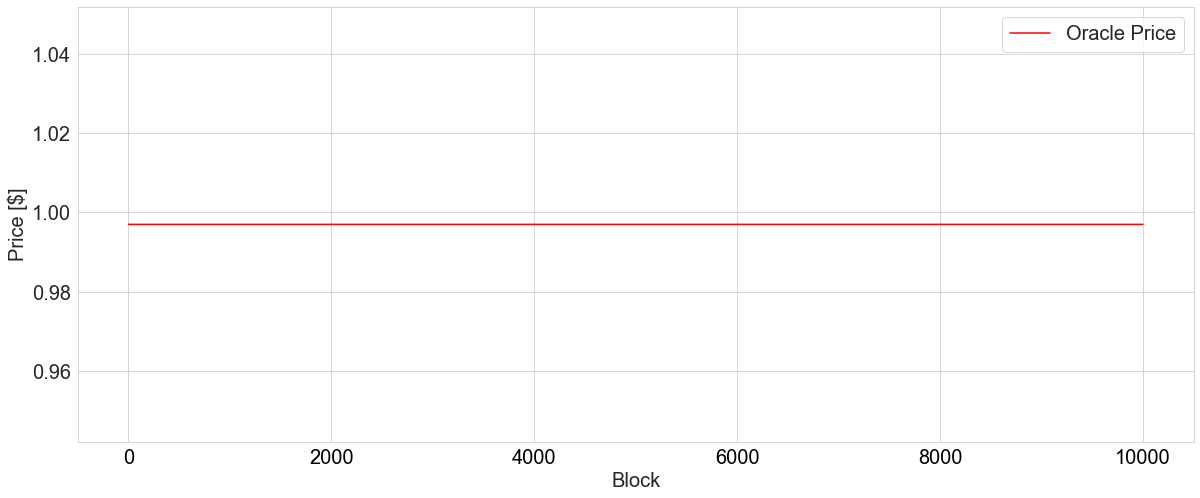

In [26]:
simulate_blips()

Pretty much constant, since nothing changes. Now we introduce a single blip in swap rate:

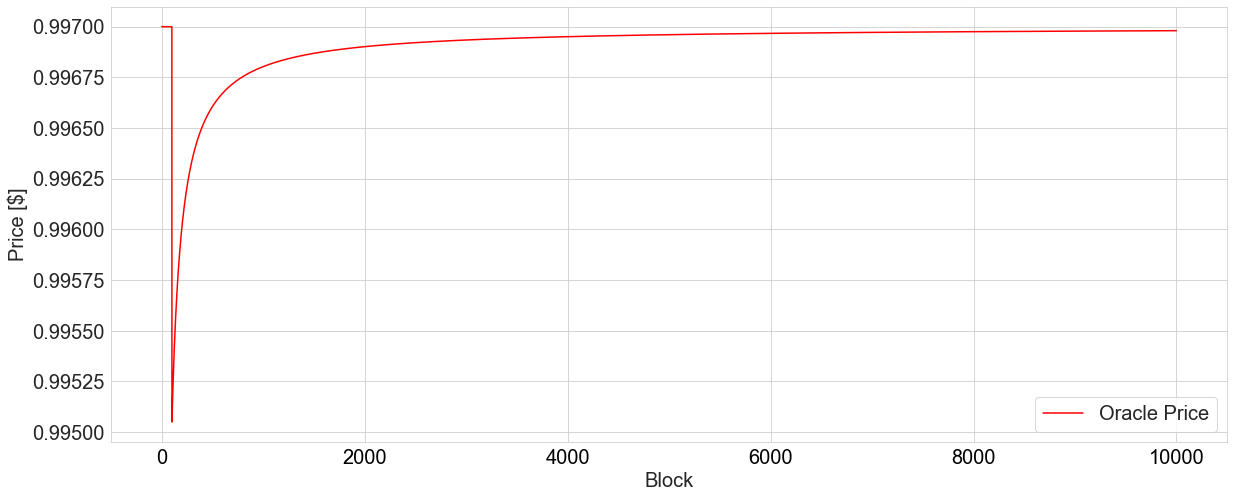

In [32]:
simulation_early_blip = simulate_blips([100], [0.8])

The pool depeg looks instantaneous. Let's  consider a blip further away from the beginning:

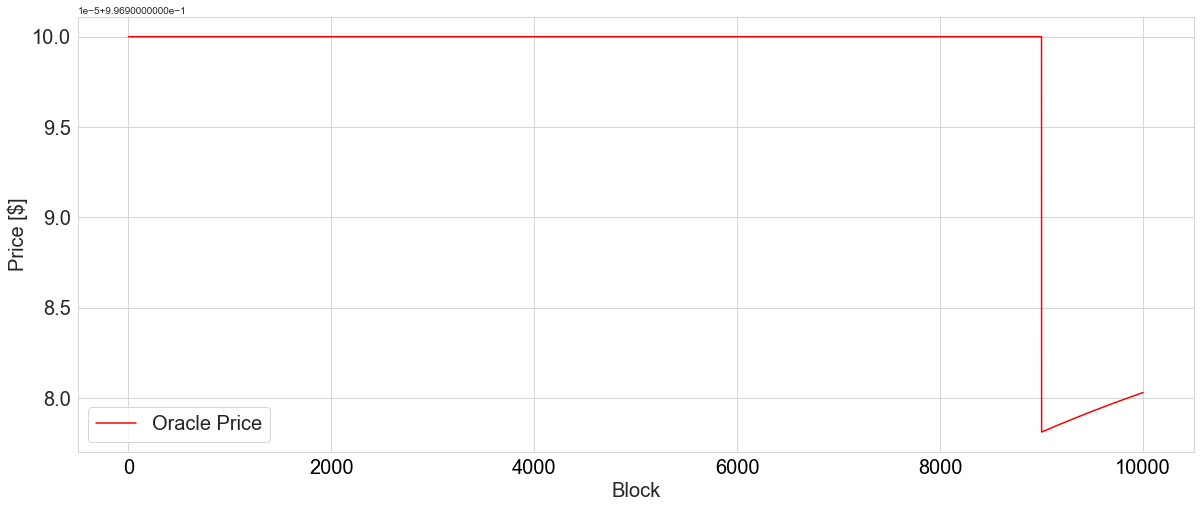

In [33]:
simulation_late_blip = simulate_blips([9000], [0.8])

The more mature the oracle, the less the blip impacts the price. Let's calculate min prices for blips simulated at each index.

In [48]:
num_blocks = 100
min_oracle_price = np.zeros((num_blocks,))
for idx in range(num_blocks):

    blip_simulation = simulate_blips([idx], [0.8], generate_plot=False, max_blocks=num_blocks)
    min_oracle_price[idx] = blip_simulation.oracle_price.min()  # how much does it dip?

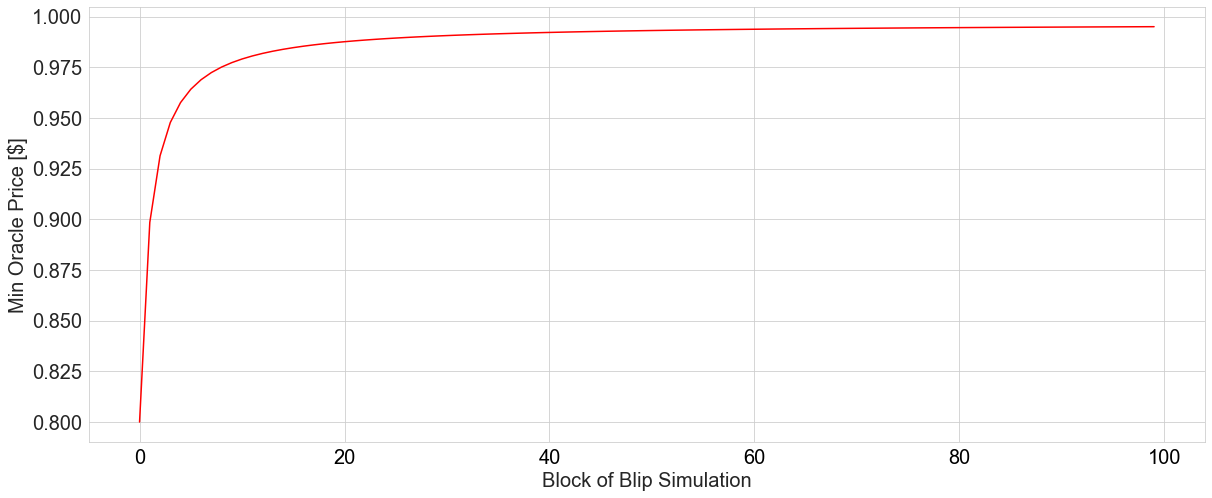

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(
    min_oracle_price,
    color='red',
)

ax.set_xlabel("Block of Blip Simulation", fontsize=20)
ax.set_ylabel("Min Oracle Price [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

These results suggest that the impact of a blip reduces to nothing the longer the averaging. This may not be the most optimal EMA calculation as, over time it completely disregards whether a blip even took place. To check, let's introduce a severe blip (severe swap rate):

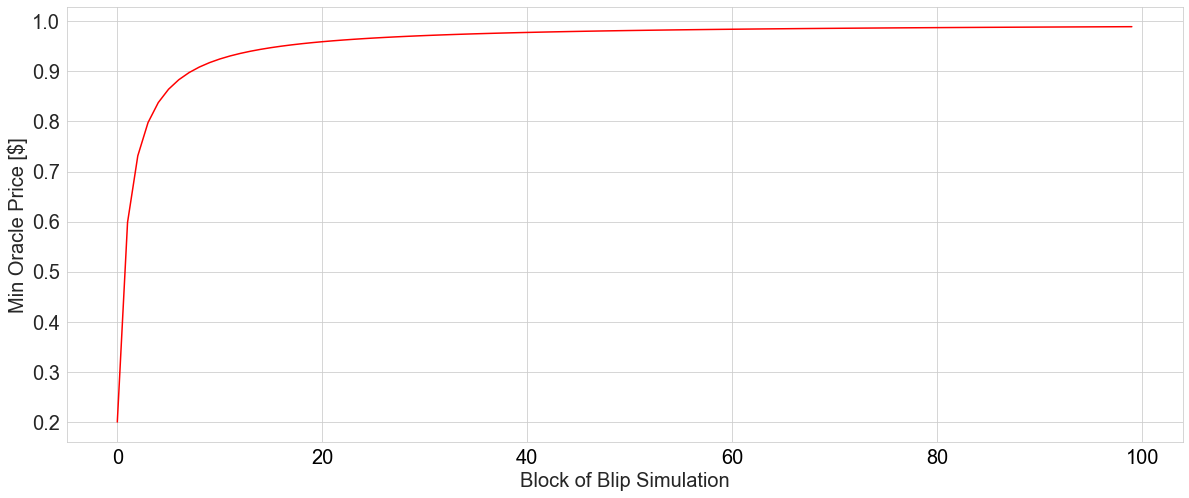

In [50]:
num_blocks = 100
min_oracle_price = np.zeros((num_blocks,))
for idx in range(num_blocks):

    blip_simulation = simulate_blips([idx], [0.2], generate_plot=False, max_blocks=num_blocks)
    min_oracle_price[idx] = blip_simulation.oracle_price.min()  # how much does it dip?

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(
    min_oracle_price,
    color='red',
)

ax.set_xlabel("Block of Blip Simulation", fontsize=20)
ax.set_ylabel("Min Oracle Price [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

The longer the averaging, the less the current events affect the EMA rate. While this makes it manipulation resistant, it may be undesirable as the oracle will not reflect the impact of cvxCRV : CRV spot rates. An averaging logic that gives more weight to more recent spot rates is hence needed.

Let's repeat the example but not with a blip: let's replace with a more consistent multi-block depeg after a blip:

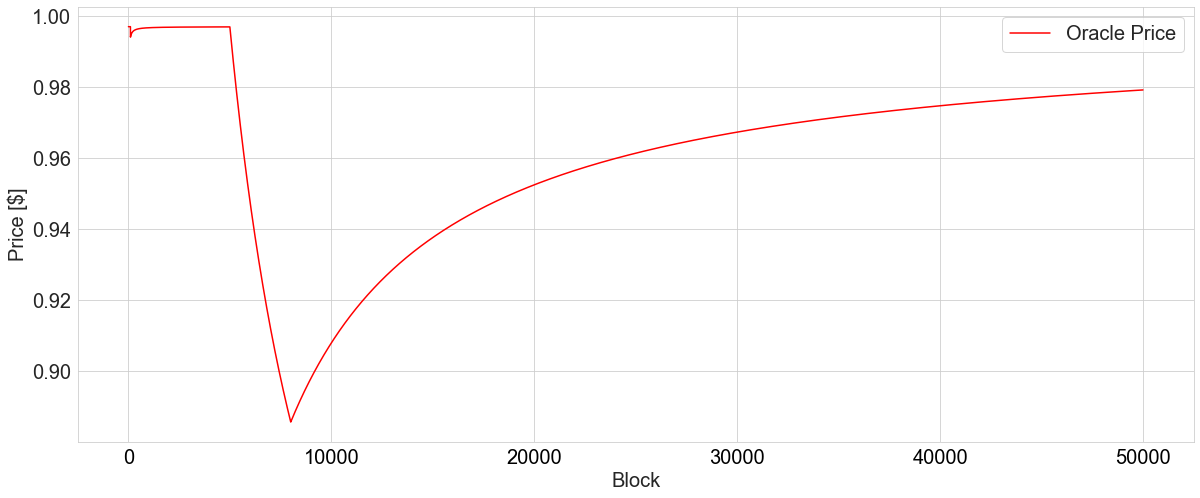

In [61]:
blip_blocks = [100] + list(range(5000, 8000))
blips = [0.7] * len(blip_blocks)
simulation_consistent_blips = simulate_blips(blip_blocks, blips, max_blocks = 50000)

In this example, an extended de-peg event has long-lasting consequences to the price: even though the peg is restored after block 8000, the price does not revert back to 1:0.997. It stays lower. This level of extreme damping may be undesirable as the oracle prices no longer resemble the price of the asset (as it lags in history).

Let's try another method of ema: https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average

![](ema_weighting.png)

The term $\alpha$ is derived from a window length $N$, which we can optimise. the relationship between $N$ and $\alpha$ is: $\alpha = 2 / (N + 1)$

In [72]:
class SlidingWindowEMAOracle(SyntheticOracle):

    def __init__(self, num_blocks_in_window: int, initial_dampened_rate: int):

        self.alpha = int(2 / (num_blocks_in_window + 1) * 1E18)
        self.dampened_rate = initial_dampened_rate

    def update_dampened_rate(self, swap_rate: int):

        self.dampened_rate = int(self.alpha * swap_rate + (1E18 - self.alpha) * self.dampened_rate)

    def latestAnswer(self, external_oracle_price: int) -> int:

        return int(
            external_oracle_price * 10**10 * self.dampened_rate / 10 ** 18
        )

In [78]:
sliding_window_EMA_oracle = SlidingWindowEMAOracle(num_blocks_in_window=1000, initial_dampened_rate=int(0.997 * 1E18))
sliding_window_EMA_oracle.update_dampened_rate(swap_rate=0.997*1E18)
sliding_window_EMA_oracle.latestAnswer(external_oracle_price=1E8) / 1E18

0.9969999999999999

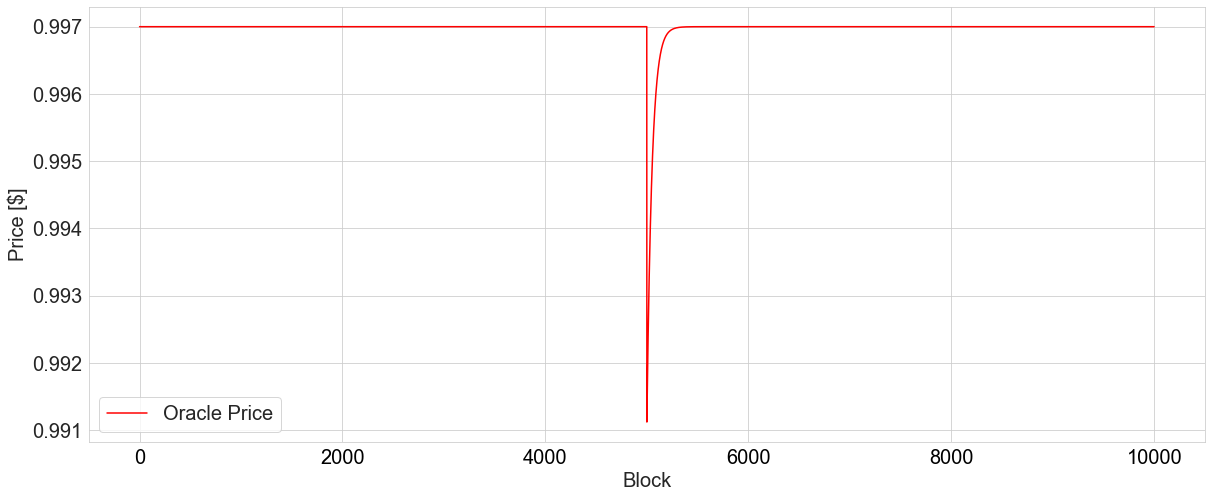

In [91]:
simulated_windowed_ema = simulate_blips(
    [5000], [0.7],
    max_blocks=10000,
    synthetic_oracle=SlidingWindowEMAOracle(num_blocks_in_window=100, initial_dampened_rate=int(0.997 * 1E18))
)

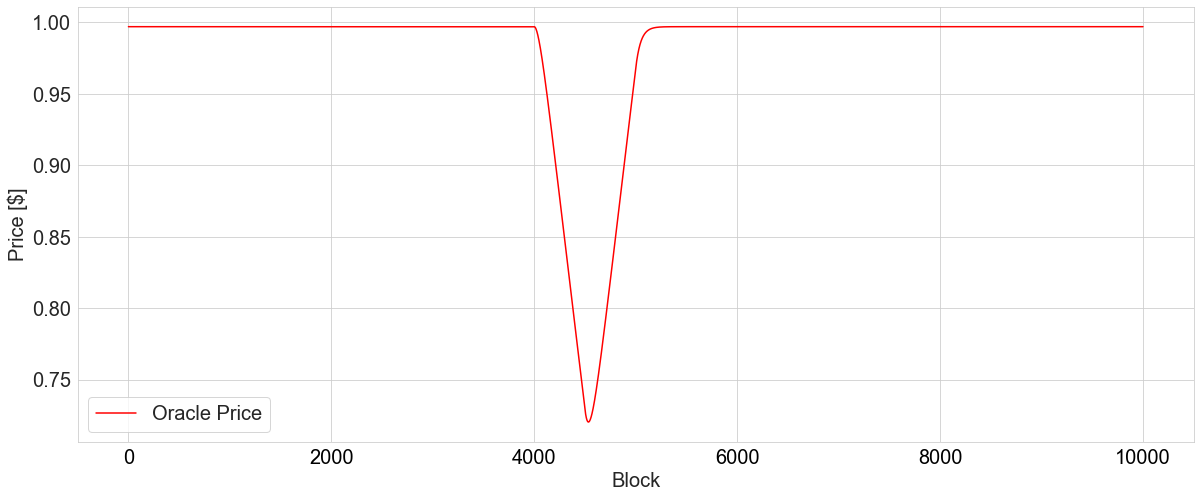

In [100]:
blip_blocks = list(range(4000, 5000))
blips = list(np.linspace(start=0.997, stop=0.7, num=500)) + list(np.linspace(start=0.7, stop=0.997, num=500))

simulated_windowed_ema_range = simulate_blips(
    blip_blocks, blips,
    max_blocks=10000,
    synthetic_oracle=SlidingWindowEMAOracle(num_blocks_in_window=100, initial_dampened_rate=int(0.997 * 1E18))
)

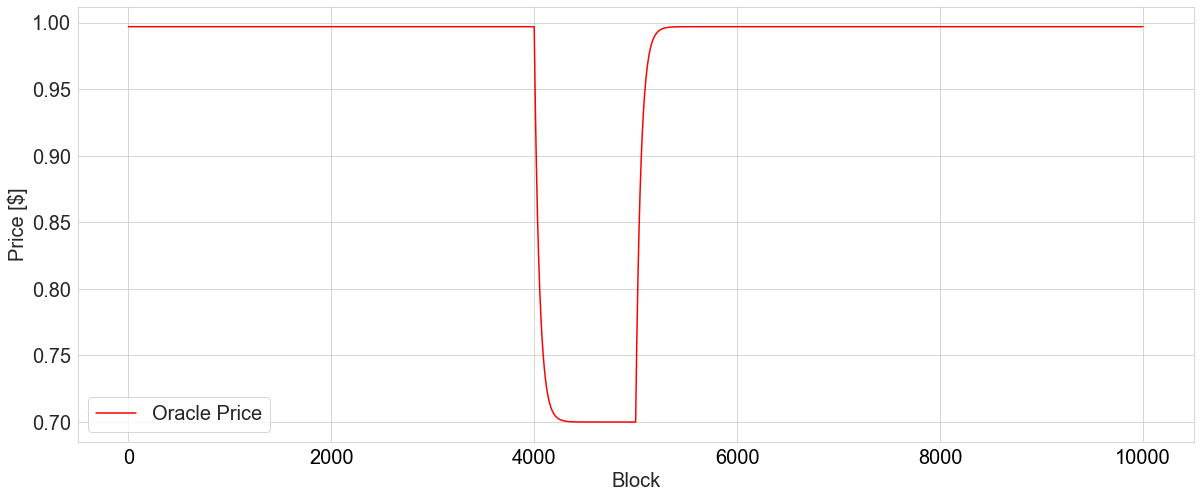

In [103]:
blip_blocks = list(range(4000, 5000))
blips = [0.7] * len(blip_blocks)

simulated_windowed_ema_range_static = simulate_blips(
    blip_blocks, blips,
    max_blocks=10000,
    synthetic_oracle=SlidingWindowEMAOracle(num_blocks_in_window=100, initial_dampened_rate=int(0.997 * 1E18))
)

Lets try a longer averaging window: this gives even more damping:

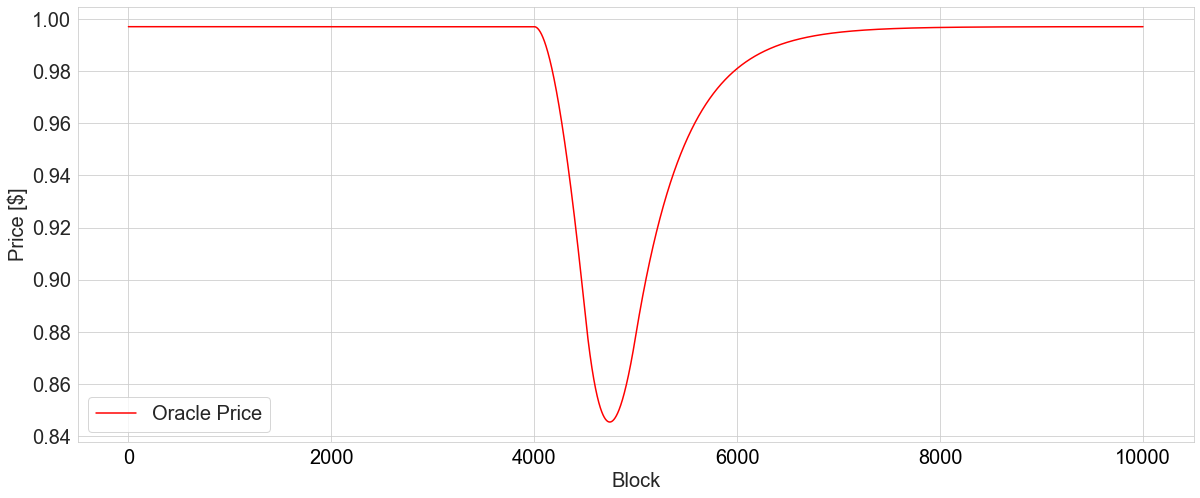

In [105]:
blip_blocks = list(range(4000, 5000))
blips = list(np.linspace(start=0.997, stop=0.7, num=500)) + list(np.linspace(start=0.7, stop=0.997, num=500))

simulated_windowed_ema_range = simulate_blips(
    blip_blocks, blips,
    max_blocks=10000,
    synthetic_oracle=SlidingWindowEMAOracle(num_blocks_in_window=1000, initial_dampened_rate=int(0.997 * 1E18))
)

Looks good: the oracle price reported is not overdamped and responds to recent spot price shifts as well. Let's go with 1000 window ema rate with a starting swap rate from latest spot.